step 1: elapsed 0.7768599987030029
step 2: elapsed 0.01671576499938965
step 3: elapsed 0.30937695503234863
-------------------------------------------
Handle transitivity:
	Intra:		 22
	Intra(choice):	 4
	Inter:		 164
	Inter(choice):	 55
-------------------------------------------
	Time =  341  ms
	result: 0

	Total cost: 43.477899713267625

# valid points:		 36
# invalid points:	 39
step 4: elapsed 0.3444654941558838
step 5: elapsed 0.0024967193603515625
elapsed 1.4512994289398193
#Humans 1


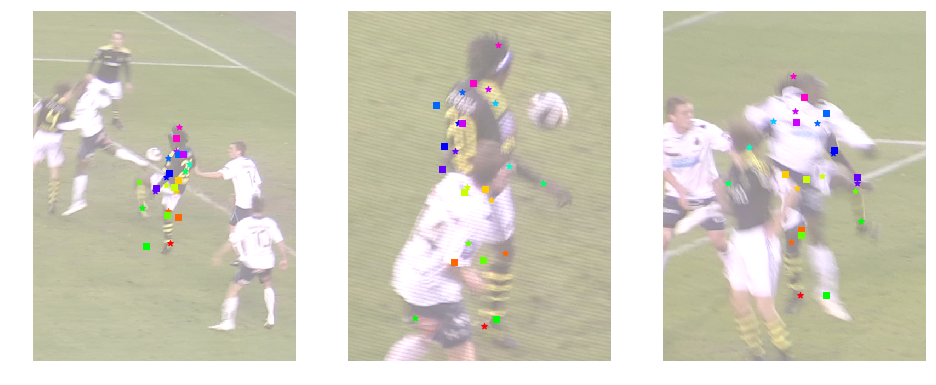

In [5]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader

from mvpose.algorithm import settings

params = settings.get_settings(scale_to_mm=1000)

colors = cs.lincolor(16).astype('float32')/255
FRAME = 85 # 85
data_root = Settings['data_root']
seq1_zipname = 'player1sequence2.zip'
seq1_dir = 'Sequence 2'
# seq1_zipname = 'player2sequence1.zip'
# seq1_dir = 'Sequence 1'
player = 1
Im, Calib, pos2d, pos3d = kth.get(
    data_root, seq1_zipname, seq1_dir, FRAME, player=player)


from mvpose.algorithm.candidate_selection import project_human_to_2d

heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME, dir='/home/julian/Temp')
_start = time()
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()
print('elapsed', _end - _start)

Humans = kth.transform3d_from_mscoco(detections)
print('#Humans', len(Humans))

fig = plt.figure(figsize=(16,10))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    joints = pos2d[:,:,cid]
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid], marker='*')

    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, Calib[cid])
        for jid, p in enumerate(human2d):
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[jid], marker='s')

plt.show()

PERSON 0
upper leg (right)=  0.5313471510467599
pelvis=  0.19661464221850528
upper leg (left)=  0.4631899102476491
lower leg (left)=  0.5362517670378707
upper arm (left)=  0.3116729118125987
lower arm (left)=  0.29057563664634567
side (left)=  0.5672824574282744
shoulder-to-chin (left)=  0.2651012662574966
head=  0.25686652890599354

PERSON 0
upper leg (right)=  0.5313471510467599
pelvis=  0.19661464221850528
upper leg (left)=  0.4631899102476491
lower leg (left)=  0.5362517670378707
upper arm (left)=  0.3116729118125987
lower arm (left)=  0.29057563664634567
side (left)=  0.5672824574282744
shoulder-to-chin (left)=  0.2651012662574966
head=  0.25686652890599354

PERSON 0
upper leg (right)=  0.5313471510467599
pelvis=  0.19661464221850528
upper leg (left)=  0.4631899102476491
lower leg (left)=  0.5362517670378707
upper arm (left)=  0.3116729118125987
lower arm (left)=  0.29057563664634567
side (left)=  0.5672824574282744
shoulder-to-chin (left)=  0.2651012662574966
head=  0.25686652890

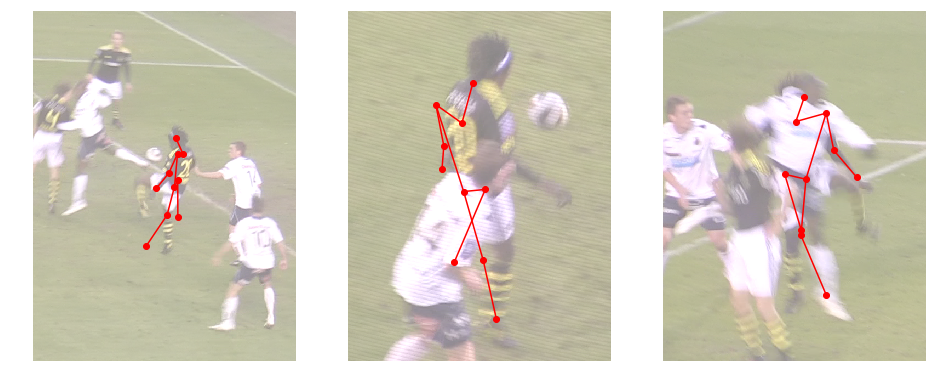

In [6]:
fig = plt.figure(figsize=(16,10))

colors = cs.lincolor(5).astype('float32')/255

for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    
    for pid, human in enumerate(Humans):
        print('PERSON', pid)
        kth.draw_limbs2d(ax, human, Calib[cid], color=colors[pid], print_length=True)
        print('')
        
plt.show()

In [ ]:
from mvpose.evaluation import pcp
import mvpose.data.skeleton_augmentation as ska

model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)
#add_missing_limbs = True

use_heuristic = True

larms = []
uarms = []
llegs = []
ulegs = []
pelvis = []
shoulder = []
head = []
all_parts = []

larms_ex = []
uarms_ex = []
llegs_ex = []
ulegs_ex = []
pelvis_ex = []
shoulder_ex = []
head_ex = []
all_parts_ex = []

for frame in range(0, 150, 5):
    _start = time()
    Im, Calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=player)
    heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
        'kth' + seq1_zipname[0:-4], Im, frame, dir='/home/julian/Temp')
    
    if use_heuristic:
        detections = pose.estimate_heuristic(
            Calib, heatmaps, pafs, settings=params)
    else:
        detections = pose.estimate(
            Calib, heatmaps, pafs, settings=params)
    
#     if add_missing_limbs:
#         detections = gen.apply(detections)
    alpha = 0.5
    
    # ~~~~~ no adding of limbs ~~~~~
    Humans = kth.transform3d_from_mscoco(detections)
    if len(Humans) > 0:
        assert len(Humans) == 1, "frame: " + str(frame) + ', len: ' + str(len(Humans))
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        larms.append(r.lower_arms)
        uarms.append(r.upper_arms)
        llegs.append(r.lower_legs) 
        ulegs.append(r.upper_legs)
        pelvis.append(r.pelvis)
        shoulder.append(r.shoulder)
        head.append(r.head)
        all_parts.append(r.all_parts)
    else:
        larms.append(0)
        uarms.append(0)
        llegs.append(0) 
        ulegs.append(0)
        pelvis.append(0)
        shoulder.append(0)
        head.append(0)
        all_parts.append(0)
    
    # ~~~~~~ adding limbs if needed ~~~~~~
    detections = gen.apply(detections)
    Humans = kth.transform3d_from_mscoco(detections)
    if len(Humans) > 0:
        assert len(Humans) == 1, "n"
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        larms_ex.append(r.lower_arms)
        uarms_ex.append(r.upper_arms)
        llegs_ex.append(r.lower_legs) 
        ulegs_ex.append(r.upper_legs)
        pelvis_ex.append(r.pelvis)
        shoulder_ex.append(r.shoulder)
        head_ex.append(r.head)
        all_parts_ex.append(r.all_parts)
    else:
        larms_ex.append(0)
        uarms_ex.append(0)
        llegs_ex.append(0) 
        ulegs_ex.append(0)
        pelvis_ex.append(0)
        shoulder_ex.append(0)
        head_ex.append(0)
        all_parts_ex.append(0)
    
    _end = time()
    print('frame ' + str(frame) + ', elapsed', _end - _start)

In [ ]:
print('+++ No limb heuristic +++')
print('lower arms:\t', np.mean(larms))
print('upper arms:\t', np.mean(uarms))
print('lower legs:\t', np.mean(llegs))
print('upper legs:\t', np.mean(ulegs))
print('pelvis:\t\t', np.mean(pelvis))
print('shoulder:\t', np.mean(shoulder))
print('head:\t\t', np.mean(head))
print('all parts:\t', np.mean(all_parts))

print('+++ With limb heuristic +++')
print('lower arms:\t', np.mean(larms_ex))
print('upper arms:\t', np.mean(uarms_ex))
print('lower legs:\t', np.mean(llegs_ex))
print('upper legs:\t', np.mean(ulegs_ex))
print('pelvis:\t\t', np.mean(pelvis_ex))
print('shoulder:\t', np.mean(shoulder_ex))
print('head:\t\t', np.mean(head_ex))
print('all parts:\t', np.mean(all_parts_ex))

In [ ]:
plt.plot(range(len(shoulder)), llegs)